# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Goal-of-this-note-book" data-toc-modified-id="Goal-of-this-note-book-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal of this note book</a></div><div class="lev1 toc-item"><a href="#Image-features-&amp;-Transformations" data-toc-modified-id="Image-features-&amp;-Transformations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Image features &amp; Transformations</a></div><div class="lev2 toc-item"><a href="#Histogram-of-Oriented-Gradients" data-toc-modified-id="Histogram-of-Oriented-Gradients-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Histogram of Oriented Gradients</a></div><div class="lev2 toc-item"><a href="#Color-Transform" data-toc-modified-id="Color-Transform-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Color Transform</a></div><div class="lev2 toc-item"><a href="#Other-Transforms" data-toc-modified-id="Other-Transforms-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Other Transforms</a></div><div class="lev2 toc-item"><a href="#Sliding-windows" data-toc-modified-id="Sliding-windows-24"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Sliding windows</a></div><div class="lev1 toc-item"><a href="#Classifier" data-toc-modified-id="Classifier-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Classifier</a></div><div class="lev2 toc-item"><a href="#Data-exploration" data-toc-modified-id="Data-exploration-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Data exploration</a></div><div class="lev2 toc-item"><a href="#Define-feature-extractors" data-toc-modified-id="Define-feature-extractors-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Define feature extractors</a></div><div class="lev2 toc-item"><a href="#Extract-features" data-toc-modified-id="Extract-features-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Extract features</a></div><div class="lev2 toc-item"><a href="#Sklearn-&amp;-Keras-modeling" data-toc-modified-id="Sklearn-&amp;-Keras-modeling-34"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Sklearn &amp; Keras modeling</a></div><div class="lev2 toc-item"><a href="#Sliding-window-search" data-toc-modified-id="Sliding-window-search-35"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Sliding window search</a></div><div class="lev2 toc-item"><a href="#Heatmap" data-toc-modified-id="Heatmap-36"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Heatmap</a></div><div class="lev1 toc-item"><a href="#Final-pipeline" data-toc-modified-id="Final-pipeline-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Final pipeline</a></div><div class="lev2 toc-item"><a href="#one-stop-pipeline" data-toc-modified-id="one-stop-pipeline-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>one-stop pipeline</a></div><div class="lev2 toc-item"><a href="#Video-process" data-toc-modified-id="Video-process-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Video process</a></div>

# Goal of this note book

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

# Image features & Transformations

- These features and transformations will be used an an input to the vehicle detection classifier

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import warnings
import skimage.feature
%matplotlib inline

In [2]:
# Helper methods (not related to image features & transformations)

def read_image(image):
    """Returns a RGB image"""
    
    image = cv2.imread(image)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def plot_image(image, cmap="gray", **kwargs):
    """Plots an image"""
    shape = image.shape
    
    if len(shape) == 2:
        plt.imshow(image, cmap=cmap, **kwargs)
        
    else:
        plt.imshow(image, **kwargs)
        
        
def plot_two_images(image_A, title_A, image_B, title_B, figsize=(15, 10)):
    plt.figure(figsize=figsize)
    
    plt.subplot(1, 2, 1)
    plot_image(image_A)
    plt.title(title_A)
    
    plt.subplot(1, 2, 2)
    plot_image(image_B)
    plt.title(title_B)

## Histogram of Oriented Gradients

As the name suggests, the Histogram of Oriented Gradients is the histogram. It counts the oriented gradients in each segment of the image.

[1] Navneet Dalal and Bill Triggs, "[Histograms of Oriented Gradients for Human Detection](http://vc.cs.nthu.edu.tw/home/paper/codfiles/hkchiu/201205170946/Histograms%20of%20Oriented%20Gradients%20for%20Human%20Detection.pdf)"

In [3]:
class Hog(object):
    """Hog Feature class

    Attributes:
        params (dict): parameters for `skimage.feature.hog`

    Examples:
        >>> hog = Hog()
        >>> hog.apply(image, hog_channel=0)

    Keyword Args:
        orientations (int): Orientations of the gradients (default: 9)
        
        pixels_per_cell (tuple): One cell is equal to ROW x COL (default: (8, 8))
            
        cells_per_block (tuple): One block consists of ROW x COL cells (default: (3, 3))            
            
        block_norm (str): {"L1", "L2", "L2-Hys"} (default: "L2-Hys)
        
        visualise (bool): Returns an image (default: False)
        
        transform_sqrt (bool): Apply power law compression to normalize (default: False)
        
        feature_vector (bool): Returns a feature vector (default: True)

    """

    def __init__(self,
                 orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3),
                 block_norm='L2-Hys',
                 visualise=False,
                 transform_sqrt=False,
                 feature_vector=True):

        self.params = {
            "orientations": orientations,
            "pixels_per_cell": pixels_per_cell,
            "cells_per_block": cells_per_block,
            "block_norm": block_norm,
            "visualise": visualise,
            "transform_sqrt": transform_sqrt,
            "feature_vector": feature_vector,
        }

    def apply(self, image, hog_channel):
        """Returns hog features from the image
        
        Args:
            image (3-D array): image in numpy array (H, W, C)
            hog_channel (int): channel of the image to extract hog features
            
        Returns:
            hog_features (1-D array): when `feature_vector` is set to True
            hog_image (2-D array, optional): when `visualise` is True
        """
        H, W, C = image.shape  
        
        if type(hog_channel) == str and hog_channel == "ALL":
            features = []
            for c in range(C):
                partial = image[..., c]
                feat = skimage.feature.hog(partial, **self.params)
                features.append(feat)
            
            return np.concatenate(features, axis=0)
        
        elif type(hog_channel) == int:
            assert hog_channel < C, "Image shape: {} Requested hog channel: {}".format(image.shape, hog_channel)
            
            partial = image[..., hog_channel]
            return skimage.feature.hog(partial, **self.params)

In [4]:
hog_params = {
    "orientations": 9,
    "pixels_per_cell": (8, 8),
    "cells_per_block": (2, 2),
    "visualise": True
}

hogger = Hog(**hog_params)

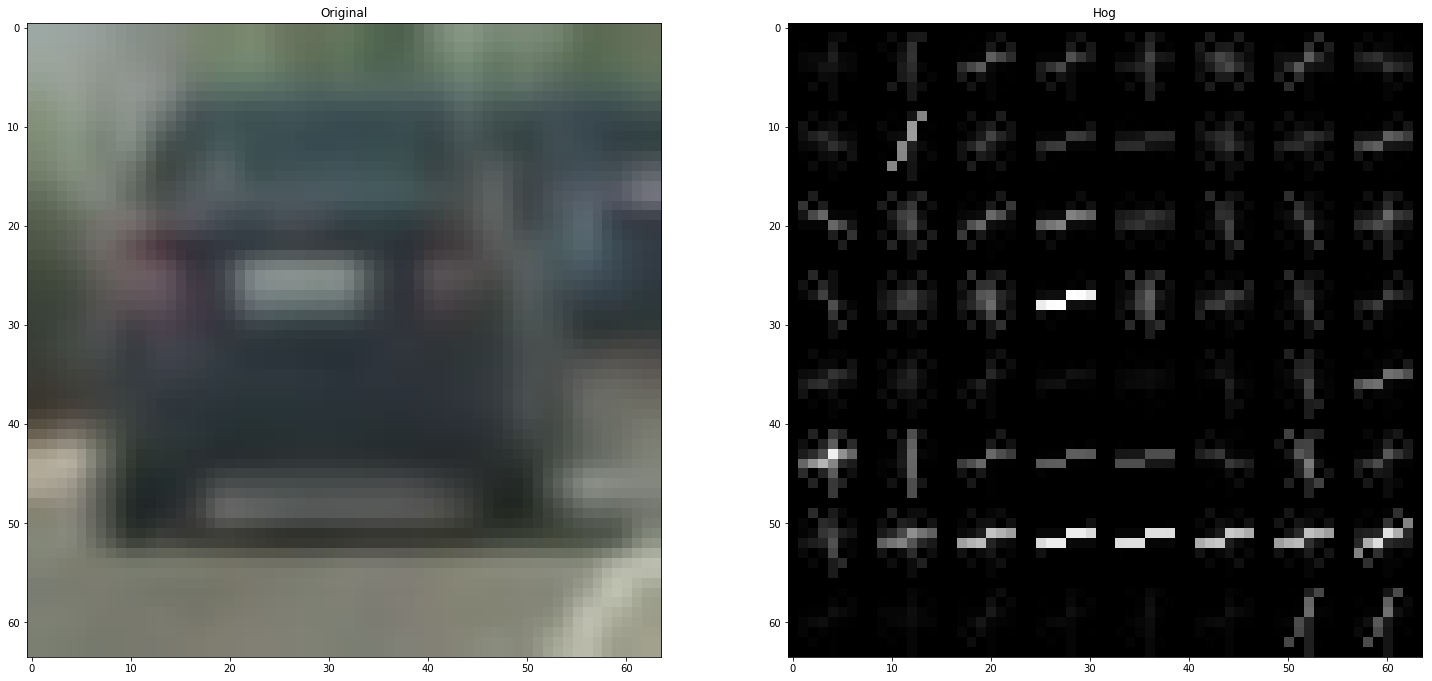

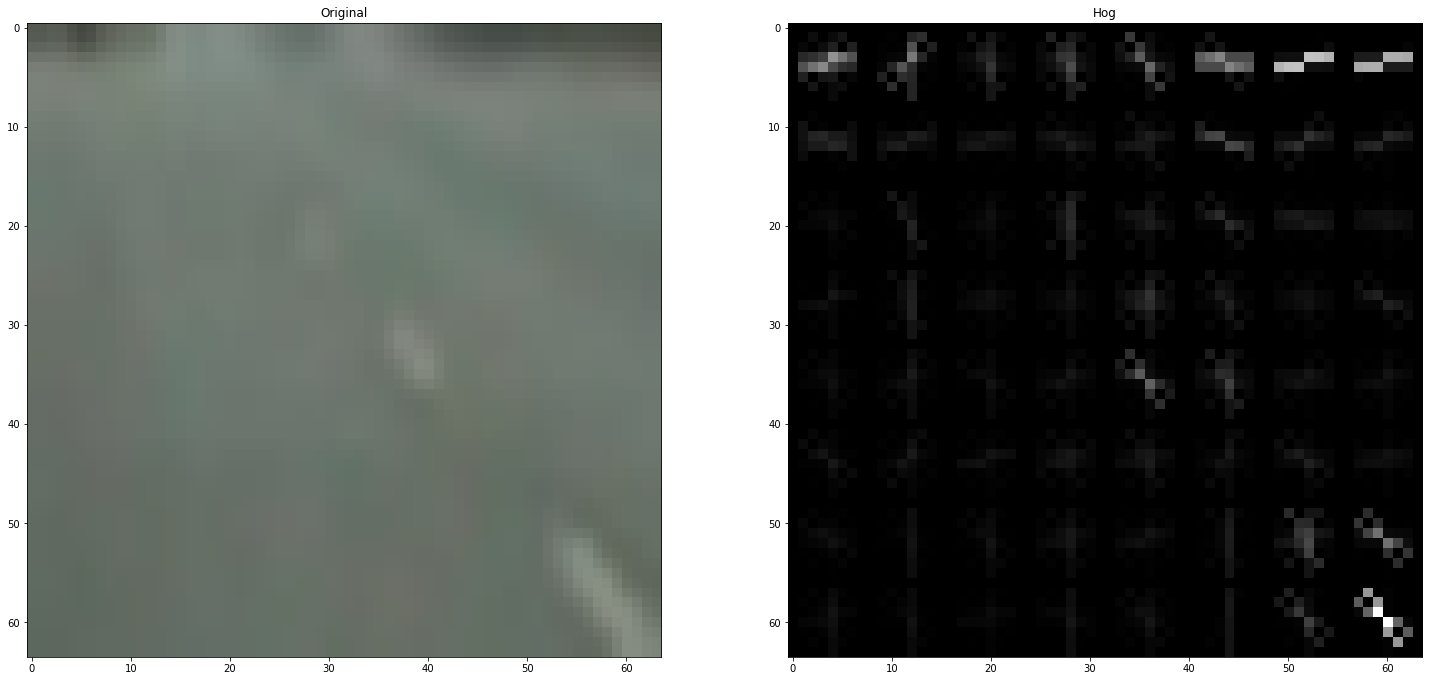

In [5]:
image = read_image("./training_images/vehicles/GTI_Far/image0000.png")
hog_feat, hog_img = hogger.apply(image, 0)
plot_two_images(image, "Original", hog_img, "Hog", figsize=(25, 20))


image = read_image("./training_images/non-vehicles/GTI/image2.png")
hog_feat, hog_img = hogger.apply(image, 0)
plot_two_images(image, "Original", hog_img, "Hog", figsize=(25, 20))

## Color Transform

In [6]:
def convert_color_space(image, color_space="RGB"):
    """Returns an image in given color space
    
    Args:
        image (array): 2-D or 3-D numpy array.
            The color space must be `RGB`
            
        color_space (str): choose one {"RGB", "HSV", "LUV", "HLS", "YUV", "YCrCb"}
        
    Returns:
        image (array): same shape as `image` but in different color space
    """
    
    if color_space == "RGB":
        return np.copy(image)
    elif color_space == "HSV":
        return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    elif color_space == "LUV":
        return cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    elif color_space == "HLS":
        return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    elif color_space == "YUV":
        return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    elif color_space == "YCrCb":
        return cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        warnings.warn("{} space is not supported".format(color_space))
        return np.copy(image)

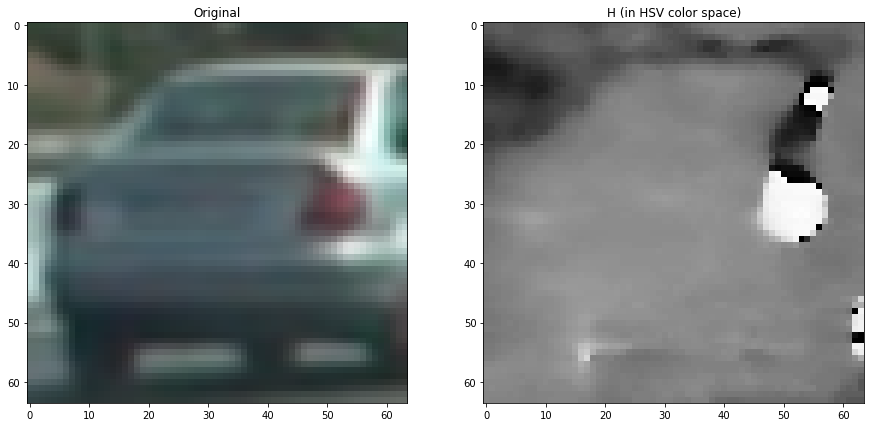

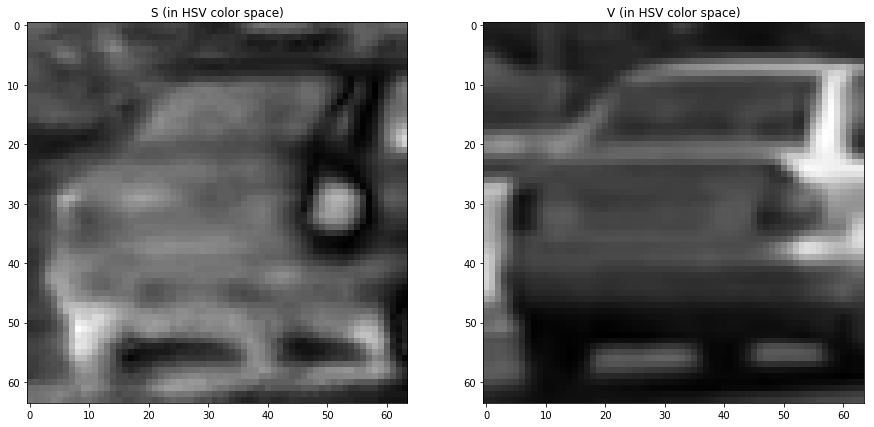

In [7]:
image = read_image("./training_images/vehicles/GTI_Left/image0009.png")
output = convert_color_space(image, color_space="HSV")

H = output[..., 0]
S = output[..., 1]
V = output[..., 2]

plot_two_images(image, "Original", H, "H (in HSV color space)")
plot_two_images(S, "S (in HSV color space)", V, "V (in HSV color space)")

## Other Transforms

In [8]:
def get_bin_spatial_features(image, size=(32, 32)):
    """Resizes the image and flatten using ravel
    
    Args:
        image (array_like): numpy image 2-D or 3-D array
        size (tuple): resizes the image to (int, int)
    
    Returns:
        1-D array: spatial(flatten) features of the resized image
    """    
    return cv2.resize(image, size).ravel()

In [9]:
def get_histogram_features(image, bins=32, bin_range=(0, 256)):
    """Returns histogram features out of the image
    
    Args:
        bins (int): number of histogram bins for `np.histogram`
        bin_range (tuple): range of color (default: (0, 256))
        
    Returns:
        1-D array: histogram features for every channel of the image
    """
    assert len(image.shape) == 3, "{} is not 3-D".format(image.shape)    
    C = image.shape[-1]
    
    features = []
    
    for i in range(C):
        hist, bins = np.histogram(image[..., i], bins, range=bin_range)
        features.append(hist)
    
    return np.concatenate(features, axis=0)

## Sliding windows

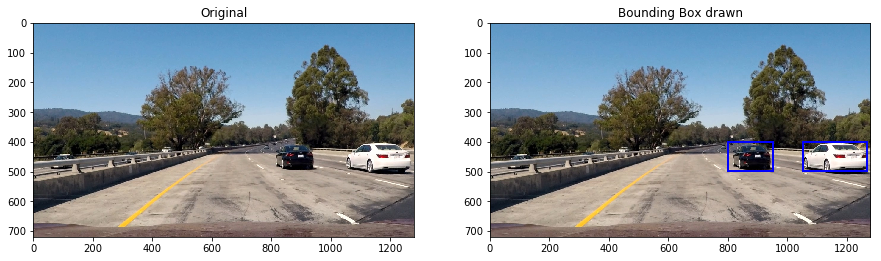

In [10]:
def draw_bboxes(image, bboxes, color=(0, 0, 255), thickness=6):
    """Returns bboxes drawn images

    Args:
        image (3-D array): numpy array (H, W, C)

        bboxes (list): each bbox consists of left-top coordinates and right-bottom coordinates

            For example, bboxes = [(`left_top`, `bottom_right`), (`left_top`, `bottom_right`), ... ]

            `left_top` = (COL, ROW). Notice it's not (ROW, COL)

    Returns:
        image (3-D array): bounding boxes are drawn on this image
    """
    image = np.copy(image)

    for left_top, right_bottom in bboxes:

        image = cv2.rectangle(image, left_top, right_bottom, color, thickness)

    return image


bboxes = [((800, 400), (950, 500)), ((1050, 400), (1265, 500))]
image = read_image("./test_images/test1.jpg")
plot_two_images(image, "Original",
                draw_bboxes(image, bboxes), "Bounding Box drawn")

In [55]:
# Helper functions for slide_windows
def get_W_H_range(image, x_start_stop, y_start_stop):
    """Returns the region to locate sliding windows"""
    H, W, C = image.shape

    W_beg, W_end = x_start_stop
    H_beg, H_end = y_start_stop

    if W_beg is None:
        W_beg = 0

    if H_beg is None:
        H_beg = 0

    if W_end is None:
        W_end = W

    if H_end is None:
        H_end = H

    return W_beg, W_end, H_beg, H_end


def get_strides(xy_window, xy_overlap):
    """Returns strides in pixel"""
    filter_w, filter_h = xy_window
    overlap_w, overlap_h = xy_overlap

    return int(filter_w * (1 - overlap_w)), int(filter_h * (1 - overlap_h))
# Helpr functions ends

def slide_windows(image, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """Returns each sliding window's position as a list

    Args:
        image (np.ndarray): (H, W, C) 3-D array
        x_start_stop (tuple): (int, int) width of the image
        y_start_stop (tuple): (int, int) height of the image
        xy_window (tuple): (int, int) Filter width/height
        xy_overlap (tuple): (float, float) how much overlapping for each slide

    Returns:

        list: each element is a tuple of (left_top, right_bottom) 
              list = [(left_top, right_bottom), (left_top, right_bottom), ...]
                   = [((W_min, H_min), (W_max, H_max)), ...]
                   
    Note:
        `x` is a `width` or horizontal coordinate
        `y` is a `height` or vertical coordinate
    """
    windows = []
    
    W_beg, W_end, H_beg, H_end = get_W_H_range(image, x_start_stop, y_start_stop)
    W_stride, H_stride = get_strides(xy_window, xy_overlap)
    W_filter, H_filter = xy_window
    
    for w in range(W_beg, W_end, W_stride):
        for h in range(H_beg, H_end, H_stride):
            
            left_top = (w, h)
            right_bottom = (w + W_filter, h + H_filter)
            
            windows.append((left_top, right_bottom))
            
    
    return windows

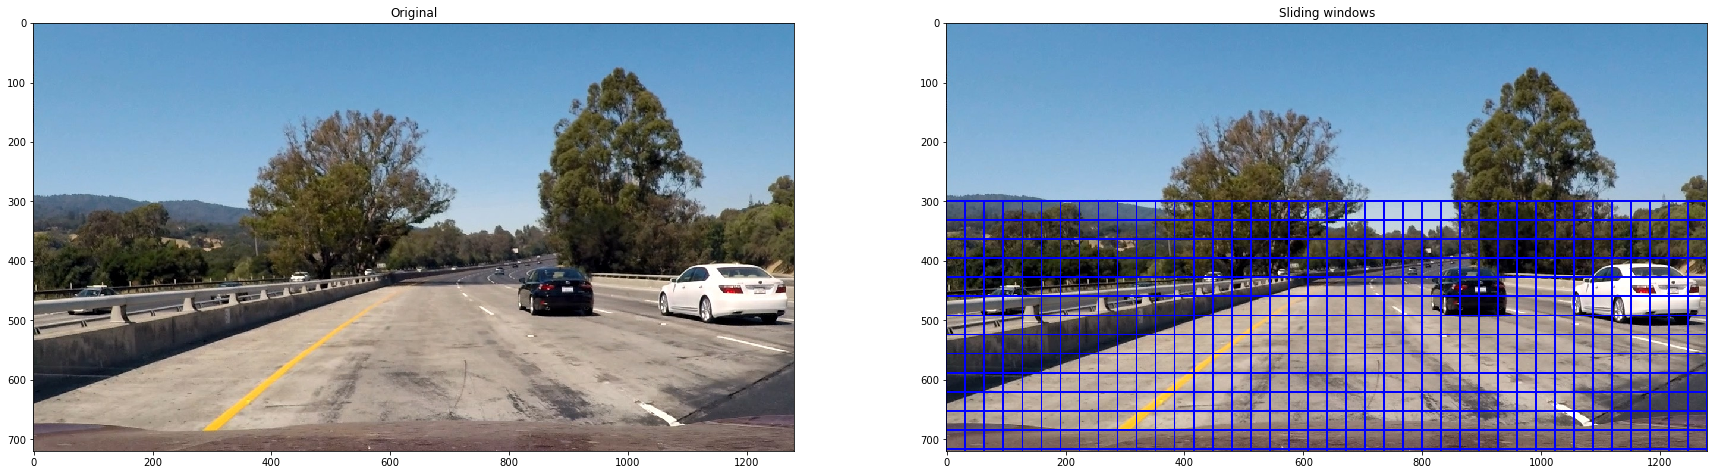

In [56]:
windows = slide_windows(image, y_start_stop=[300, None], xy_overlap=(0.5, 0.5))
image = read_image("./test_images/test1.jpg")
plot_two_images(image, "Original", draw_bboxes(image, windows, thickness=2), "Sliding windows", figsize=(30, 15))

# Classifier

In [57]:
import sklearn
import glob
import tqdm

## Data exploration

In [58]:
car_images = glob.glob("training_images/vehicles/*/*", recursive=True)
nocar_images = glob.glob("training_images/non-vehicles/*/*", recursive=True)

8792 8968


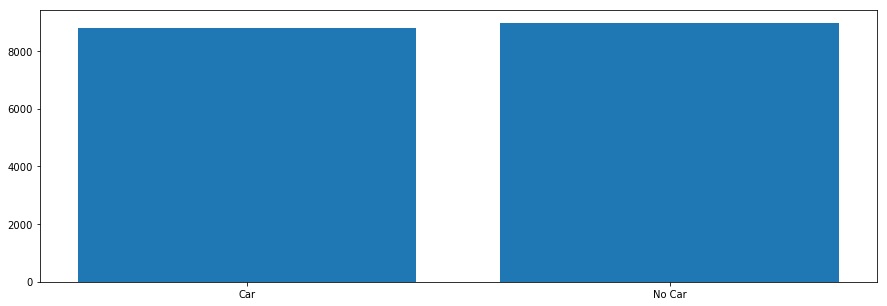

In [59]:
# Make sure the labels are distributed equally
plt.figure(figsize=(15, 5))
plt.bar([0, 1], [len(car_images), len(nocar_images)])
plt.xticks([0, 1], ["Car", "No Car"]);
print(len(car_images), len(nocar_images))

In [60]:
training_data = car_images + nocar_images
training_labels = np.array([1] * len(car_images) + [0] * len(nocar_images))

assert len(training_data) == training_labels.shape[0]
assert len(training_labels.shape) == 1

print("There are", len(training_data), "training data")

There are 17760 training data


## Define feature extractors

In [61]:
def extract_feature_from_single_image(image,
                                      color_space='RGB',
                                      spatial_size=(32, 32),
                                      hist_bins=32,
                                      hog=None, hog_channel=0,
                                      spatial_feat=True, hist_feat=True, hog_feat=True):
    """Extract features from single image

        1) Change Color space
        2) Get spatial features
        3) Get histogram features
        4) Get hog features

    Args:
        image (3-D array): RGB image array shape (H, W, C)
        color_space (str): choose one {"RGB", "HSV", "LUV", "HLS", "YUV", "YCrCb"}
        spatial_size (tuple): image size for spatial_features
        hist_bins (int): histogram bins
        hog_channel (int or str): channel (int) or "ALL" for all
        spatial_feat (bool): spatial features array shape (spatial_size[0] * spatial_size[1], )
        hist_feat (bool): shape (32 * n_channel, )
        hog_feat (bool): hog features

    Returns:
        features (1-D array): numpy array shape (n_dimensions, )
    """
    features = []
    
    image = convert_color_space(image, color_space)
    
    if spatial_feat:
        feat = get_bin_spatial_features(image, spatial_size)        
        features.append(feat)
    
    if hist_feat:
        feat = get_histogram_features(image, hist_bins)
        features.append(feat)
    
    if hog_feat:            
        feat = hog.apply(image, hog_channel)
        features.append(feat)
        
    return np.concatenate(features, axis=0)

In [62]:
def extract_features(images,
                     color_space='RGB',
                     spatial_size=(32, 32),
                     hist_bins=32,
                     hog=None, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    """Extract features from multiple images(path)

        1) Change Color space
        2) Get spatial features
        3) Get histogram features
        4) Get hog features

    Args:
        images (list): ["/path/to/image", "/path/to/another/image", ...]
        color_space (str): choose one {"RGB", "HSV", "LUV", "HLS", "YUV", "YCrCb"}
        spatial_size (tuple): image size for spatial_features
        hist_bins (int): histogram bins
        hog_channel (int or str): channel (int) or "ALL" for all
        spatial_feat (bool): spatial features array shape (spatial_size[0] * spatial_size[1], )
        hist_feat (bool): shape (32 * n_channel, )
        hog_feat (bool): hog features

    Returns:
        features (2-D array): numpy array shape (n_samples, n_dimensions)
    """
    features = []
    
    for image in tqdm.tqdm(images):
        
        image = read_image(image)        
        feat = extract_feature_from_single_image(image, color_space, spatial_size, hist_bins, hog, hog_channel, spatial_feat, hist_feat, hog_feat)
        
        features.append(feat)
        
    return np.vstack(features)

In [63]:
from multiprocessing.pool import Pool

In [64]:
def extract_features_multi(images,
                           color_space='RGB',
                           spatial_size=(32, 32),
                           hist_bins=32,
                           hog=None, hog_channel=0,
                           spatial_feat=True, hist_feat=True, hog_feat=True):
    """Extract features from multiple images(path)
    
    [Multiprocessing version]
    
        1) Change Color space
        2) Get spatial features
        3) Get histogram features
        4) Get hog features

    Args:
        images (list): ["/path/to/image", "/path/to/another/image", ...]
        color_space (str): choose one {"RGB", "HSV", "LUV", "HLS", "YUV", "YCrCb"}
        spatial_size (tuple): image size for spatial_features
        hist_bins (int): histogram bins
        hog_channel (int or str): channel (int) or "ALL" for all
        spatial_feat (bool): spatial features array shape (spatial_size[0] * spatial_size[1], )
        hist_feat (bool): shape (32 * n_channel, )
        hog_feat (bool): hog features

    Returns:
        features (2-D array): numpy array shape (n_samples, n_dimensions)
    """
    features = []
    
    try:
        pool = Pool()

        args = [
            (read_image(image), color_space, spatial_size, hist_bins, hog, hog_channel, spatial_feat, hist_feat, hog_feat) for image in images
        ]
        result = pool.starmap_async(extract_feature_from_single_image, args)    
        
    finally:
        pool.close()
        pool.join()
        
        features = result.get()

    return np.vstack(features)

## Extract features

In [65]:
hog_params = {
    "orientations": 9,
    "pixels_per_cell": (8, 8),
    "cells_per_block": (2, 2),
    "visualise": False
}

hog = Hog(**hog_params)

In [66]:
params = {
    "color_space": 'YCrCb',
    "spatial_size": (32, 32),
    "hist_bins": 32,
    "hog": hog,
    "hog_channel": "ALL",
    "spatial_feat": True, 
    "hist_feat": True, 
    "hog_feat": True,
}

X = extract_features_multi(training_data, **params)
y = training_labels

## Sklearn & Keras modeling

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.models import Model
from keras import layers
from keras import callbacks

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

N_train = X_train.shape[0]
N_test = X_test.shape[0]

print("X_train.shape:", X_train.shape)
print("N_test:", N_test)

X_train.shape: (13320, 8460)
N_test: 4440


In [69]:
X = layers.Input(shape=(X_train.shape[1],))

In [70]:
def build_inference(X, hidden_dims=[512, 512]):
    
    net = X
    
    for h_dim in hidden_dims:
        net = layers.Dense(h_dim)(net)
        net = layers.BatchNormalization()(net)
        net = layers.Activation("relu")(net)
        net = layers.Dropout(0.5)(net)
        
    net = layers.Dense(1)(net)
    net = layers.Activation("sigmoid")(net)
    
    return net

In [71]:
net = build_inference(X)

model = Model(inputs=X, outputs=net)
model.compile("adam", "binary_crossentropy", ["accuracy"])

In [72]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 8460)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               4332032   
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
activation_4 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
__________

In [73]:
cutoff_callback = callbacks.EarlyStopping(monitor="val_loss", patience=3, mode="min")

In [92]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[cutoff_callback])

Train on 13320 samples, validate on 4440 samples
Epoch 1/100
13320/13320 [==============================] - 2s - loss: 0.0107 - acc: 0.9965 - val_loss: 0.0276 - val_acc: 0.9926
Epoch 2/100
13320/13320 [==============================] - 2s - loss: 0.0165 - acc: 0.9944 - val_loss: 0.0179 - val_acc: 0.9953
Epoch 3/100
13320/13320 [==============================] - 2s - loss: 0.0112 - acc: 0.9972 - val_loss: 0.0189 - val_acc: 0.9937
Epoch 4/100
13320/13320 [==============================] - 2s - loss: 0.0112 - acc: 0.9961 - val_loss: 0.0190 - val_acc: 0.9939
Epoch 5/100
13320/13320 [==============================] - 2s - loss: 0.0142 - acc: 0.9955 - val_loss: 0.0193 - val_acc: 0.9941
Epoch 6/100
13320/13320 [==============================] - 2s - loss: 0.0125 - acc: 0.9962 - val_loss: 0.0172 - val_acc: 0.9937
Epoch 7/100
13320/13320 [==============================] - 2s - loss: 0.0077 - acc: 0.9976 - val_loss: 0.0172 - val_acc: 0.9948
Epoch 8/100
13320/13320 [==============================

Probability being a car: 0.9999988079071045


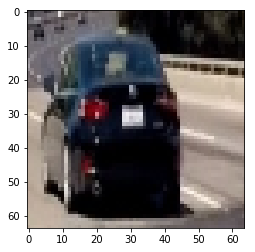

In [93]:
partial_image = image[400:500, 800:1000, :]
partial_image = cv2.resize(partial_image, (64, 64))
plot_image(partial_image)

feat = extract_feature_from_single_image(partial_image, **params)
feat = np.expand_dims(feat, 0)
feat = scaler.transform(feat)

print("Probability being a car: {}".format(np.squeeze(model.predict(feat))))

## Sliding window search

In [76]:
from functools import partial

In [94]:
def search_windows(image, windows, extract_feature_fn, clf, scaler=None, confidence=0.5, trained_size=(64, 64)):

    bbox = []

    for left_top, right_bottom in windows:

        W_beg, H_beg = left_top
        W_end, H_end = right_bottom

        partial_image = image[H_beg:H_end, W_beg:W_end, :]
        partial_image = cv2.resize(partial_image, trained_size)
        feat = extract_feature_fn(partial_image)

        feat = np.expand_dims(feat, 0)

        if scaler:
            feat = scaler.transform(feat)

        prob = np.squeeze(clf.predict(feat))

        if prob > confidence:

            bbox.append((left_top, right_bottom))

    return bbox

In [95]:
extract_feature_fn = partial(extract_feature_from_single_image, **params)

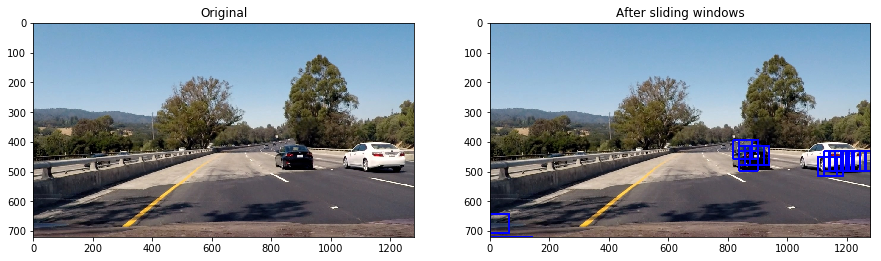

In [96]:
image = read_image("test_images/test4.jpg")

windows = slide_windows(image, y_start_stop=[300, None], xy_overlap=(0.7, 0.7))
bbox = search_windows(image, windows, extract_feature_fn, model, scaler)
plot_two_images(image, "Original", draw_bboxes(image, bbox), "After sliding windows")

## Heatmap

In [83]:
from scipy.ndimage import label

In [84]:
def make_heatmap(heatmap, bbox):
    
    for left_top, right_bottom in bbox:
        
        W_beg, H_beg = left_top
        W_end, H_end = right_bottom
        
        heatmap[H_beg:H_end, W_beg:W_end] += 1
    
    return heatmap

In [85]:
def filter_heatmap(heatmap, filter):
    
    heatmap[heatmap < filter] = 0
    
    return heatmap

In [86]:
def get_bboxes_from_labeled_heatmap(label_heatmap, labels):
    bbox = []
    
    for label in range(labels):
        
        nonzero = np.nonzero(label_heatmap == label + 1)
        nonzero_row = nonzero[0]
        nonzero_col = nonzero[1]
        
        left_top = (min(nonzero_col), min(nonzero_row))
        right_bot = (max(nonzero_col), max(nonzero_row))
        
        bbox.append((left_top, right_bot))
        
    return bbox

In [99]:
heatmap = np.zeros_like(image[..., 0])
heatmap = make_heatmap(heatmap, bbox)
heatmap = filter_heatmap(heatmap, 0)

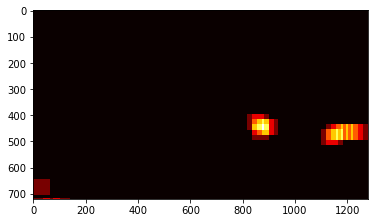

In [100]:
plot_image(heatmap, cmap="hot")

In [45]:
labeled_heatmap, n_labels = label(heatmap)
print("There are ", n_labels, "cars detected")

There are  4 cars detected


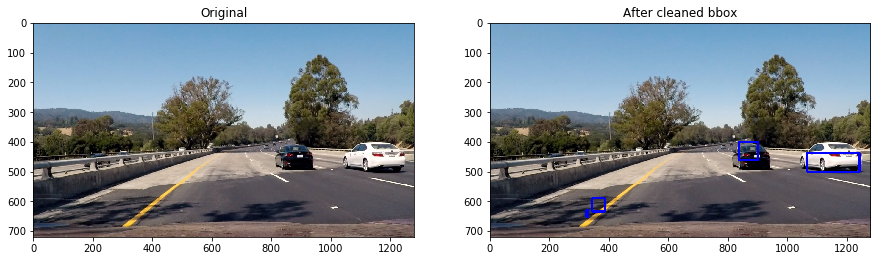

In [46]:
clean_bbox = get_bboxes_from_labeled_heatmap(labeled_heatmap, n_labels)
plot_two_images(image, "Original", draw_bboxes(image, clean_bbox), "After cleaned bbox")

# Final pipeline

## one-stop pipeline

In [47]:
def pipeline(image):
    
    windows = slide_windows(image, y_start_stop=[300, 650], xy_overlap=(0.3, 0.3))
    bbox = search_windows(image, windows, extract_feature_fn, model, scaler)
    
    heatmap = np.zeros_like(image[..., 0])
    heatmap = make_heatmap(heatmap, bbox)
    heatmap = filter_heatmap(heatmap, 3)
    
    labeled_heatmap, n_labels = label(heatmap)
    clean_bbox = get_bboxes_from_labeled_heatmap(labeled_heatmap, n_labels)
    
    return draw_bboxes(image, clean_bbox)    

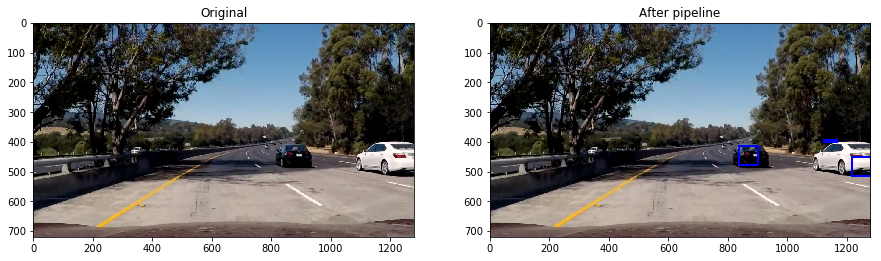

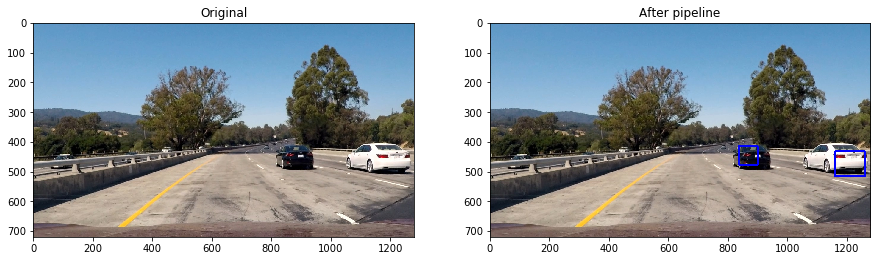

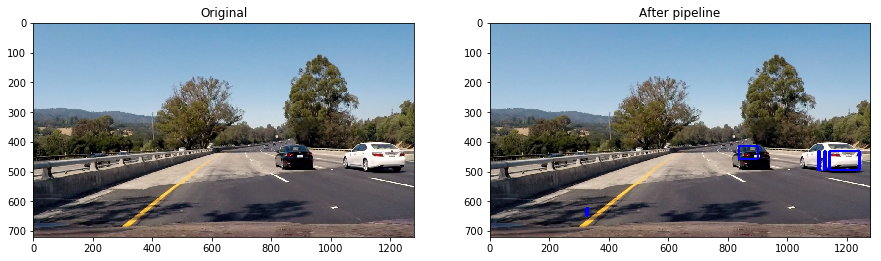

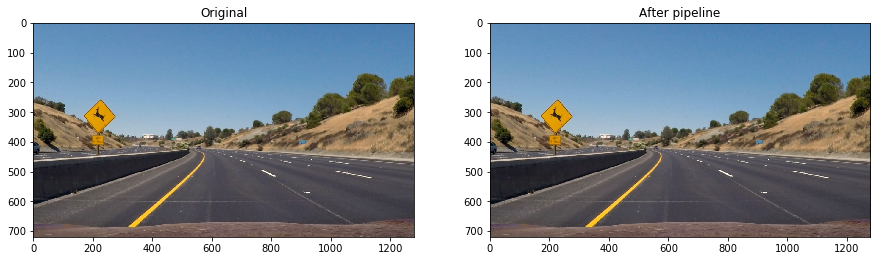

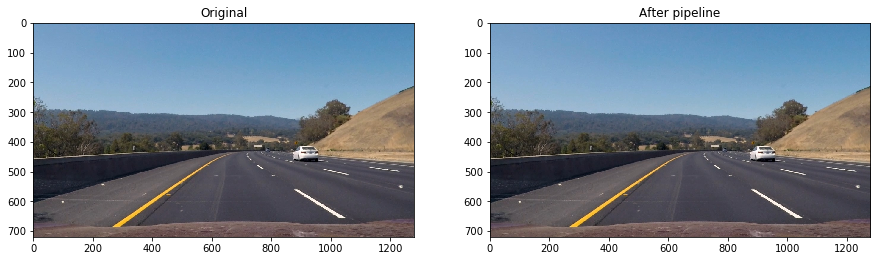

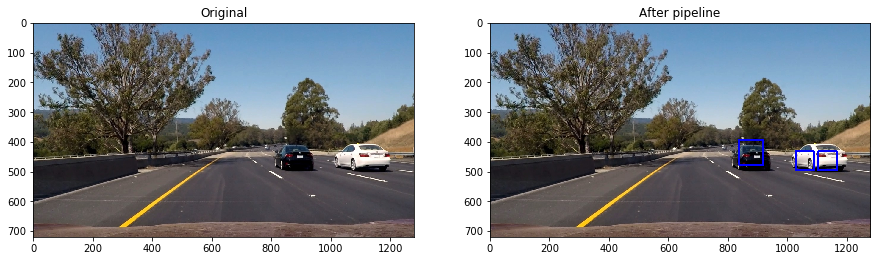

In [48]:
images = glob.glob("test_images/*.jpg")
for image in images:
    image = read_image(image)
    plot_two_images(image, "Original", pipeline(image), "After pipeline")

## Video process

In [49]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [50]:
output = 'out.mp4'
clip = VideoFileClip("test_video.mp4")
clip = clip.fl_image(pipeline)

%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video out.mp4
[MoviePy] Writing video out.mp4


 97%|█████████▋| 38/39 [04:13<00:06,  6.73s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out.mp4 

CPU times: user 8min 6s, sys: 1min 6s, total: 9min 13s
Wall time: 4min 13s


In [51]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))